In [2]:
#hide
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

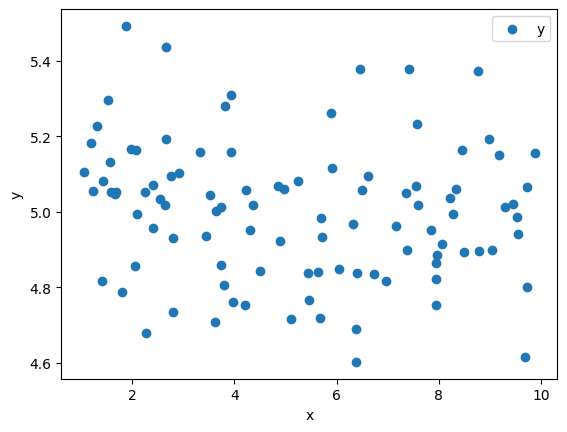

In [3]:
np.random.seed(42)
x = np.random.uniform(1, 10, 100)
y = np.random.normal(5, 0.2, size=x.shape)

## ask for what is the intetion of this line in Nicolas's code
plt.scatter(x,y, label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [54]:
# model prediction
pred = 5
reg  = 0 # regularization

# g stands for gradient and h stands for hessian
# g = 2*(y-x)*x from the mean square error
g = np.array([2*(i-pred)*i for i in y])
h = np.array([-2*i for i in y])

# The optimal weight for the model is the negative sum of the gradient divided by the sum of the hessian
# We can see this in the XG Boost paper
w = -g.sum()/(h.sum()+ reg)

print(f'the optimal weight is {w:.4} for the model with a constant prediction of y={pred}')

the optimal weight is -0.5907 for the model with a constant prediction of y=5


In [55]:
# model prediction
pred = 1

# g stands for gradient and h stands for hessian
# g = 2*(y-x)*x from the mean square error
g = np.array([2*(i-pred)*i for i in y])
h = np.array([-2*i for i in y])

# The optimal weight for the model is the negative sum of the gradient divided by the sum of the hessian
# We can see this in the XG Boost paper
w = -g.sum()/(h.sum()+ reg)

print(f'the optimal weight is {w:.4} for the model with a constant prediction of y={pred}')

the optimal weight is 3.409 for the model with a constant prediction of y=1


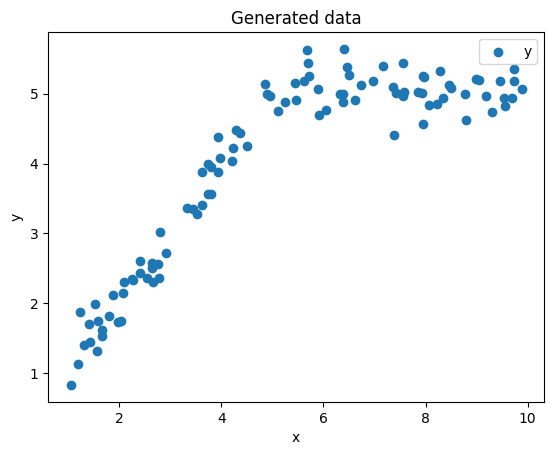

In [56]:

y = np.where(x < 5, x,5) + np.random.normal(0, 0.3, size=x.shape)
#x = x.reshape(-1,1)

df = pd.DataFrame({"X":x,"y":y})

plt.scatter(df["X"],df["y"], label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated data')
plt.legend();

The optimal threshold value of 9.882


Text(0, 0.5, 'Split impact')

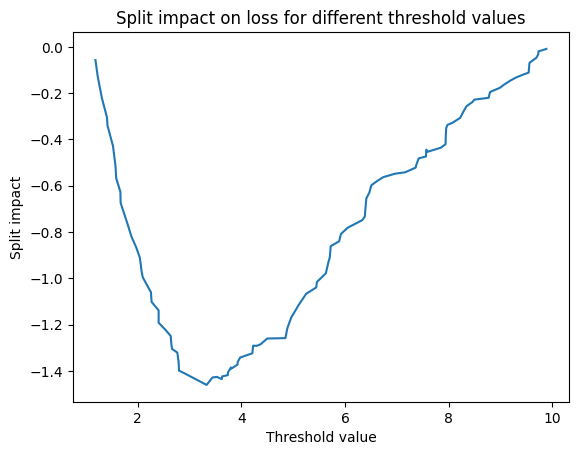

In [19]:
f_0 = np.mean(y) # initial prediction using the mean of the target

#Compute gradient and hessian of each sample
df["g"] = 2*(df["y"]-f_0)/len(df["y"])  # is this correct?
df["h"] = -2/len(df["y"])               # is this correct?


df = df.sort_values(by=['X'])
df.reset_index(inplace = True, drop = True)
#df.reset_index(inplace = True, drop = True) # We are not using the index anymore

#Keep track of the loss
l = [] 

#Test the different threshold, this is to find the optimal threshold to split the data
# Each threshold will be tested on the whole dataset
for i in range(len(df)):
    opt_split = np.inf
    # select the threshold to split the data
    t = df["X"][i]
    df_L =  df[df["X"]<t]
    df_R =  df[df["X"]>=t]
    
    G, H =np.sum(df["g"]), np.sum(df["h"])
    
    G_L = np.sum(df_L["g"])
    G_R = np.sum(df_R["g"])
    
    H_L = np.sum(df_L["h"])
    H_R = np.sum(df_R["h"])
    
    if (H==0) or (H_R==0) or (H_L ==0):
        continue
    
    # Compute the contribution of the split to the loss
    # check the XG Boost paper for the formula
    split = 1/2*((G_L**2)/H_L + (G_R**2)/H_R - (G**2)/H)
    
    l.append(split)
    
    opt_split = min(opt_split, split)
    
    if split == opt_split:
        x_opt = df["X"][i]

print(f'The optimal threshold value of {x_opt:.4}')
plt.plot(df["X"][1:],l)
plt.title("Split impact on loss for different threshold values")
plt.xlabel("Threshold value")
plt.ylabel("Split impact")

In [20]:

#Compute the new leaf weights
def split(df, x_opt):
    # split the data into two parts
    df_left  = df[df["X"]<x_opt]
    df_right = df[df["X"]>x_opt]
    # compute the gradient and hessian for each part
    G_Left = np.sum(df_left["g"])
    H_Left = np.sum(df_left["h"])
    
    G_Right = np.sum(df_right["g"])
    H_Right = np.sum(df_right["h"])

    w_left = -G_Left/H_Left
    w_right = -G_Right/H_Right
    
    return w_left, w_right

w_left, w_right = split(df, x_opt)

print(f'The optimal weight for the left leaf is {w_left:.4}')
print(f'The optimal weight for the right leaf is {w_right:.4}')

The optimal weight for the left leaf is -0.009549
The optimal weight for the right leaf is nan


C:\Users\hecma\AppData\Local\Temp\ipykernel_24952\799607989.py:14: RuntimeWarning: invalid value encountered in double_scalars
  w_right = -G_Right/H_Right


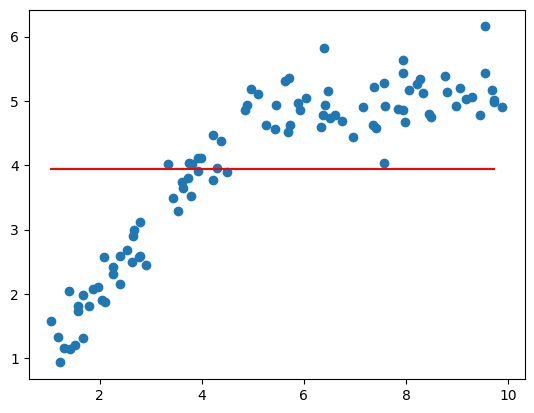

In [21]:
f_1 = []

for i in df["X"]: 
    if i<x_opt:
        f_1.append(f_0 + w_left)
    else :
        f_1.append(f_0 + w_right)

plt.figure()
plt.scatter(df["X"],df["y"])
plt.plot(df["X"],f_1, color = "red")

In [335]:

def generate_histograms(X, y, y_pred , n_bins = 10):
        """Generate the histogram representation of the data
        
        Returns:
        client_df: The dataframe of the client data with the gradient and hessian
        histograms: The histogram representation of the data per feature
                    histograms[i] = histogram of feature i. Each histogram is a dataframe with the following columns:
                                    "feature": the feature name
                                    "gradient": the gradient of the objective function for the feature
                                    "hessian": the hessian of the objective function for the feature
                                    "bin": the bin of the histogram
                                    the histogram for regression is the sum of the gradient and hessian
        """        
        
        ## Check if I need the y output if I already have the gradient and hessian
        client_df = pd.DataFrame(X)
        client_df["gradient"] = -2*(y.reshape(-1,1) - y_pred.reshape(-1,1))/ len(y)
        client_df["hessian"]  = 2/ len(y)
        
        # Must be a histogram for each feature
        histograms = [None]*(client_df.shape[1]-2)
        
        for i, feature in enumerate(client_df.columns):
            # skip the gradient and hessian
            if feature == "gradient" or feature == "hessian":
                continue
            # get the histogram of the feature and the gradient and hessian
            hist = client_df[[feature, "gradient", "hessian"]].copy()
            hist["bin"] = pd.qcut(client_df[feature], n_bins, duplicates = "drop") # check if should drop duplicates
            feat1 = hist.groupby("bin").agg({"gradient": "sum", "hessian": "sum"})
            feat1["bin"] = feat1.index.map(lambda x: x.mid).astype(float)
            histograms[i] = feat1.reset_index(drop = True)
            del hist # delete the hist dataframe to save memory
            
        return client_df, histograms

In [336]:
X = df["X"].values.reshape(-1,1)
y = df["y"].values.reshape(-1,1)
y_pred = y.mean()

client_df, histograms = generate_histograms(X, y, y_pred , n_bins = 25)
#feat1 = histograms[0].groupby("bin").agg({"gradient": "sum", "hessian": "sum"})
#feat1["bin"] = feat1.index.map(lambda x: x.mid).astype(float)
#feat1.reset_index(inplace = True, drop = True)
feat1 = histograms[0]
histograms[0]

,gradient,hessian,bin
0,0.213071,0.08,1.2260
1,0.188674,0.08,1.4935
2,0.183842,0.08,1.7265
3,0.163187,0.08,1.9820
4,0.126279,0.08,2.2495
5,0.120735,0.08,2.5325
6,0.113227,0.08,2.7700
7,0.063982,0.08,3.2350
8,0.021441,0.08,3.6845
9,0.002480,0.08,3.8680


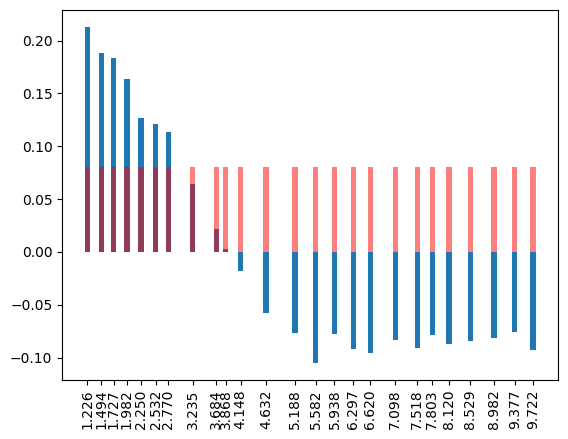

In [337]:
plt.bar(feat1["bin"], feat1["gradient"], width = 0.1)
plt.bar(feat1["bin"], feat1["hessian"], width = 0.1, color = "red", alpha = 0.5)
plt.xticks(feat1["bin"], rotation = 90)
plt.show()
plt.close()

In [338]:
def get_split_value_one_feature(histogram, lambda_ = 0.1, gamma = 0.1):
    """Compute the split value for a feature histogram
    
    Returns:
    split_value: the split value for the histogram
    """
    # Initialize the score for each bin
    
    score = [None]*len(histogram)
    # Compute the total gradient and hessian
    g = histogram["gradient"].sum()
    h = histogram["hessian"].sum()
    # Compute the score for each bin
    
    for i, bin_ in enumerate(histogram["bin"]):
        if i == 0:
            score[i] = 0
            continue
        # Gets the gradient and hessian for the left and right part of the histogram (wheights)
        g_left = histogram["gradient"][:i].sum()
        h_left = histogram["hessian"][:i].sum()
        
        g_right = histogram["gradient"][i:].sum()
        h_right = histogram["hessian"][i:].sum()
        
        # Compute the score for left and right part of the histogram
        score[i] = (g_left**2/(h_left + lambda_) + g_right**2/(h_right + lambda_) - g**2/(h + lambda_))*0.5 - gamma
    
    # Get the split value and the index of the split
    split_value = histogram["bin"][np.argmax(score)]
    index_split = score.index(max(score))
    # Compute the weights for the left and right part of the histogram
    w_left = -histogram["gradient"][:index_split].sum()/(histogram["hessian"][:index_split].sum() + lambda_)
    w_right = -histogram["gradient"][index_split:].sum()/(histogram["hessian"][index_split:].sum() + lambda_)
    
    return score , split_value, w_left, w_right


## first it will be symmetric, then I will add the missing values
# The histogram should be already built for each feature, it includes the gradient and hessian
def build_tree(trees, histograms, lambda_ = 0.1, gamma = 0.1, max_depth = 2, max_leaves = 4, feature = 0):
    
    depth = 0
    leaves = 0 
    node = 0
    # Is the list of trees empty?
    if len(trees["tree_n"]) == 0:
        new_tree = 0
    else:
        new_tree = trees["tree_n"].max() + 1
        
    # Initialize the node counter
    
    # Do a first split for the root node
    # TODO: select the feature with the highest gain 
    #feature = np.random.choice(len(X_hist))
    # ID tree-0 ROOT NODE
    ID = str(new_tree) + "-" + str(node) 
    score , split_value, _, _ = get_split_value_one_feature(histograms[feature], lambda_ , gamma)
    # Add the root node to the tree
    node += 1
    yes = str(new_tree) + "-" + str(node) # takes the left values of the split 
    node += 1
    no  = str(new_tree) + "-" + str(node)
    # Compute the gain for the split
    gain = -histograms[feature]["gradient"].sum()**2/(histograms[feature]["hessian"].sum() + lambda_) 
    #missing = str(new_tree) + "-" + str(node + 3)
    
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": node-2,
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value,
                        "yes": yes,
                        "no": no,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    trees = trees.append(new, ignore_index = True)
    depth += 1
    leaves += 2
    splits = [split_value]
##############################################################################################
    # split the data into two parts
    hist_left  = histograms[feature][histograms[feature]["bin"] <= split_value]
    hist_right = histograms[feature][histograms[feature]["bin"] >  split_value].reset_index(drop = True)
    # Get the score for the left node
    score, split_value_l, wl_left, wl_right = get_split_value_one_feature(hist_left , lambda_ , gamma)
    score, split_value_r, wr_left, wr_right = get_split_value_one_feature(hist_right, lambda_ , gamma)
    # Left node
    ID = yes
    node += 1
    ID_left = str(new_tree) + "-" + str(node)
    node += 1
    ID_right = str(new_tree) + "-" + str(node)
    gain = -hist_left["gradient"].sum()**2/(hist_left["hessian"].sum() + lambda_)
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": yes[-1],
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value_l,
                        "yes": ID_left,
                        "no": ID_right,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Left leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": ID_left[-1],
                        "feature": "Leaf",
                        "ID": ID_left,
                        "depth": depth+1,
                        "split_value": split_value_l,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wl_left}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Right leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": ID_right[-1],
                        "feature": "Leaf",
                        "ID": ID_right,
                        "depth": depth+1,
                        "split_value": split_value_l,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wl_right}, index = [0])
    trees = trees.append(new, ignore_index = True)
    
    
    # Right node
    ID = no
    node += 1
    ID_left = str(new_tree) + "-" + str(node)
    node += 1
    ID_right = str(new_tree) + "-" + str(node)
    gain = -hist_right["gradient"].sum()**2/(hist_right["hessian"].sum() + lambda_)
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": no[-1],
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value_r,
                        "yes": ID_left,
                        "no": ID_right,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Left leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": ID_left[-1],
                        "feature": "Leaf",
                        "ID": ID_left,
                        "depth": depth+1,
                        "split_value": None,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wr_left}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Right leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n":ID_right[-1],
                        "feature": "Leaf",
                        "ID": ID_right,
                        "depth": depth+1,
                        "split_value": None,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wr_right}, index = [0])
    trees = trees.append(new, ignore_index = True)
              
    return trees

def predict_tree(tree, X, y_init ):
    """Predict the target value for a given tree
    """
    x = X.values.reshape(-1,1)
    i = 0 # start at the root node
    feature = tree["feature"].values[i]
    
    while True:
        
        if tree["feature"].values[i] == "Leaf":
            return y_init + tree["gain_w"].values[i]
        
        elif x[feature] <= tree["split_value"].values[i]:
            i = tree[tree["ID"] == tree["yes"].values[i]].index[0]

        elif x[feature] > tree["split_value"].values[i]:
            i = tree[tree["ID"] == tree["no"].values[i]].index[0]
            

def built_ensamble(histograms, nuber_of_trees, lambda_ = 0.1, gamma = 0.1, max_depth = 2, max_leaves = 4, feature = 0, trees = None):
    """Build an ensamble of trees
    """
    if trees is None:
        print("No trees")
        print("Initilize the tree dataframe")
        print("trees = pd.DataFrame(columns = ['tree_n', 'node_n' ,'feature', 'ID', 'depth', 'split_value', 'yes', 'no', 'missing', 'gain_w'])")
        return None
    
    
    for i in range(nuber_of_trees):
        trees = build_tree(trees, histograms, lambda_ , gamma, max_depth, max_leaves, feature)
    return trees


(-1.8328062615098915, 0.8624970642399475)

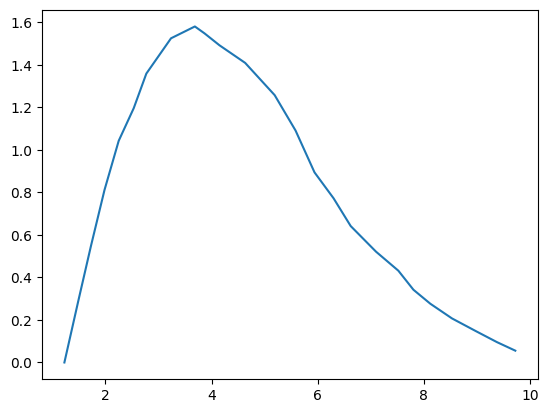

In [339]:
lambda_ = 0
gamma = 0
score , split_value, w_left, w_right = get_split_value_one_feature(feat1, lambda_, gamma)
plt.plot(feat1["bin"], score)
w_left, w_right

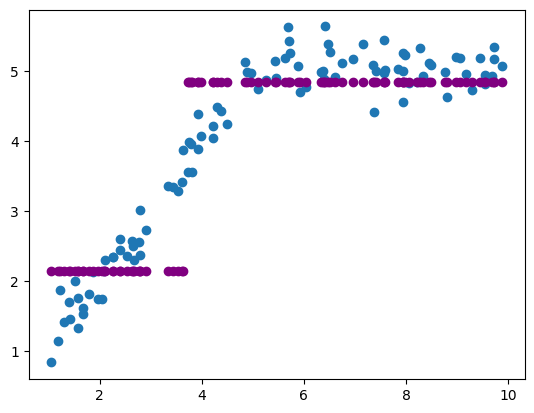

In [340]:
predictions = y_pred + [w_left if i<split_value else w_right for i in df["X"]]
plt.figure()
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"],predictions, color = "purple")

next_hist1 = feat1.where(feat1["bin"]>split_value).dropna()
next_hist2 = feat1.where(feat1["bin"]<=split_value).dropna()


In [341]:
trees = pd.DataFrame(columns = ["tree_n", "node_n", "feature", "ID", "depth", "split_value", "yes", "no", "missing", "gain_w"])
trees = build_tree(trees, histograms, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 0)

C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

In [342]:
X = df["X"]
X = pd.DataFrame(X)
X.shape
x1 = X.iloc[0]
x1.values

array([4.37086107])

In [343]:
trees = pd.DataFrame(columns = ["tree_n", "node_n" ,"feature", "ID", "depth", "split_value", "yes", "no", "missing", "gain_w"])
trees = built_ensamble(histograms, 1, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 0, trees = trees)

C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

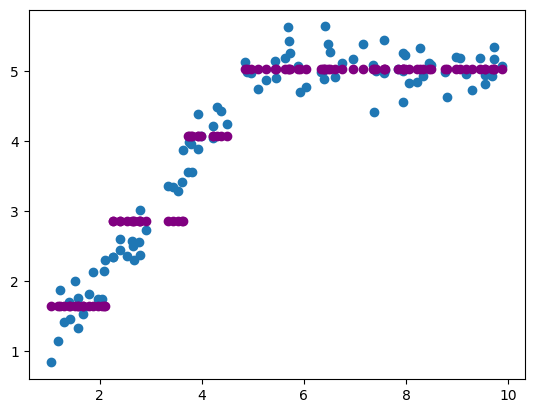

In [344]:
y_predict = [predict_tree(trees,X.iloc[i] , y_init = y.mean()) for i in range(len(X))]
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"],y_predict, color = "purple")

In [345]:
y_predict = np.array(y_predict)
client_df, histograms = generate_histograms(df["X"].values.reshape(-1,1), df["y"].values.reshape(-1,1),y_predict, n_bins = 25)

<BarContainer object of 25 artists>

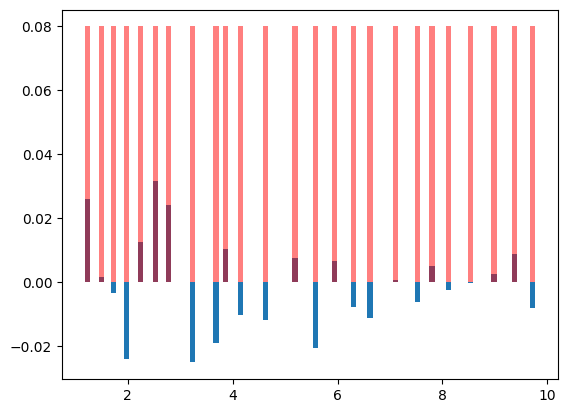

In [346]:
plt.bar(histograms[0]["bin"], histograms[0]["gradient"], width = 0.1)
plt.bar(histograms[0]["bin"], histograms[0]["hessian"], width = 0.1, color = "red", alpha = 0.5)

In [347]:
tree2 = build_tree(trees, histograms, lambda_ , gamma, max_depth = 2, max_leaves = 4, feature = 0)

C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

In [348]:
def predict_esnamble(trees, X, y_init):
    """Predict the target value for a given ensamble of trees
    """
    y_pred = y_init
    
    for i in range(trees["tree_n"].max() ):
        tree = trees[trees["tree_n"] == i].copy().reset_index(drop = True)
        y_pred = predict_tree(tree, X, y_pred)
        
    return y_pred

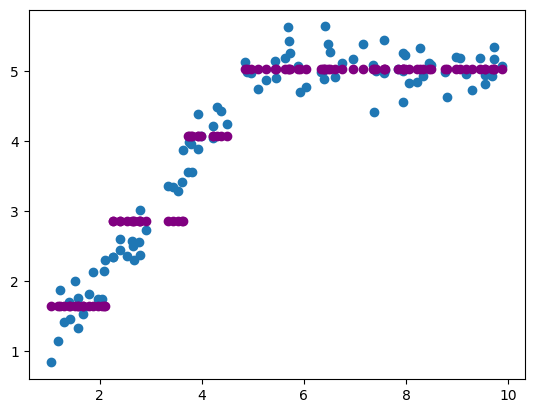

In [349]:
y_predict = [predict_esnamble(tree2, X.iloc[i], y_init = y.mean()) for i in range(len(X))]
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"],y_predict, color = "purple")

In [350]:
tree3 = build_tree(tree3, histograms, lambda_ = 0.01, gamma = 0.01, max_depth = 2, max_leaves = 4, feature = 0)

C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_34604\2660281051.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

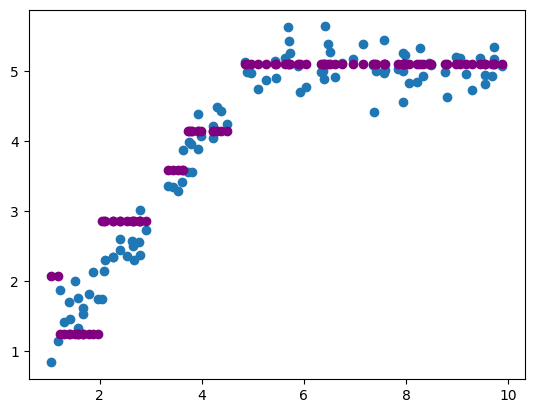

In [356]:
y_predict = [predict_esnamble(tree3, X.iloc[i], y_init = y.mean()) for i in range(len(X))]
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"], y_predict, color = "purple")